In [1]:
import os
import pandas as pd
from tqdm import tqdm
import shutil
from src import utils
from scipy.stats import spearmanr
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Project path
project_dir = os.path.abspath('')[:-9]
# Load enviromental variables

env_var = utils.load_env_variables(project_dir)
env_var["root_path"] = "/home/tpinho/IJGIS/Datasets/NSW_Election_2019/"

In [3]:
dataset = "Original"
scv_methods = { "Optimistic": "Optimistic",  "RegGBSCV_R_Kappa_0.0": "RGraphSCV", "TraditionalSCV": "Conservative"}
ml_method = "LGBM"
fs_method = "CFS"
latlon = "LatLon"
metric = "MCPM"

br_folds = {
   "35":{
      "sigla":"SP",
      "nome":"São Paulo"
   },
   "41":{
      "sigla":"PR",
      "nome":"Paraná"
   },
   "42":{
      "sigla":"SC",
      "nome":"Santa Catarina"
   },
   "43":{
      "sigla":"RS",
      "nome":"Rio Grande do Sul"
   },
   "50":{
      "sigla":"MS",
      "nome":"Mato Grosso do Sul"
   },
   "11":{
      "sigla":"RO",
      "nome":"Rondônia"
   },
   "12":{
      "sigla":"AC",
      "nome":"Acre"
   },
   "13":{
      "sigla":"AM",
      "nome":"Amazonas"
   },
   "14":{
      "sigla":"RR",
      "nome":"Roraima"
   },
   "15":{
      "sigla":"PA",
      "nome":"Pará"
   },
   "16":{
      "sigla":"AP",
      "nome":"Amapá"
   },
   "17":{
      "sigla":"TO",
      "nome":"Tocantins"
   },
   "21":{
      "sigla":"MA",
      "nome":"Maranhão"
   },
   "24":{
      "sigla":"RN",
      "nome":"Rio Grande do Norte"
   },
   "25":{
      "sigla":"PB",
      "nome":"Paraíba"
   },
   "26":{
      "sigla":"PE",
      "nome":"Pernambuco"
   },
   "27":{
      "sigla":"AL",
      "nome":"Alagoas"
   },
   "28":{
      "sigla":"SE",
      "nome":"Sergipe"
   },
   "29":{
      "sigla":"BA",
      "nome":"Bahia"
   },
   "31":{
      "sigla":"MG",
      "nome":"Minas Gerais"
   },
   "33":{
      "sigla":"RJ",
      "nome":"Rio de Janeiro"
   },
   "51":{
      "sigla":"MT",
      "nome":"Mato Grosso"
   },
   "52":{
      "sigla":"GO",
      "nome":"Goiás"
   },
   "53":{
      "sigla":"DF",
      "nome":"Distrito Federal"
   },
   "22":{
      "sigla":"PI",
      "nome":"Piauí"
   },
   "23":{
      "sigla":"CE",
      "nome":"Ceará"
   },
   "32":{
      "sigla":"ES",
      "nome":"Espírito Santo"
   }
}

In [4]:
results = {"Folds": [], metric: [], "SCV": [], "TRAIN_SIZE": []}
path = os.path.join(env_var["root_path"], dataset, "results")
cv_metrics_lat_lon = pd.read_csv(os.path.join(path, "CrossValidation", "evaluations", latlon, ml_method, "metrics_with_mcpm.csv"))

for scv_method in scv_methods:
    metrics_latlon = pd.read_csv(os.path.join(path, scv_method, "evaluations", latlon, ml_method, "metrics_with_mcpm.csv"))
    metrics_latlon = metrics_latlon[metrics_latlon["TEST_SIZE"]>10]
    metrics_latlon["FOLD"] = metrics_latlon["FOLD"].astype(str)
    if scv_method == "Optimistic":
        metrics_latlon.sort_values(by=metric, inplace=True)
        indexes = metrics_latlon["FOLD"]
    else:
        metrics_latlon.set_index("FOLD", inplace=True)
        metrics_latlon = metrics_latlon.loc[indexes]
        metrics_latlon.reset_index(inplace=True)
    metrics_latlon = metrics_latlon[metrics_latlon["FOLD"] != "53" ]
    metrics_latlon = metrics_latlon[metrics_latlon["FOLD"] != "Hawaii" ]
    metrics_latlon = metrics_latlon[metrics_latlon["FOLD"] != "Delaware" ]
    results["Folds"] = results["Folds"] + metrics_latlon["FOLD"].values.tolist()
    results[metric] = results[metric] + metrics_latlon[metric].values.tolist()
    results["SCV"] = results["SCV"] + [scv_methods[scv_method]]*len(metrics_latlon)
    results["TRAIN_SIZE"] = results["TRAIN_SIZE"] + metrics_latlon["TRAIN_SIZE"].values.tolist()
    


metric_results = pd.DataFrame(results)
metric_results


,Folds,MCPM,SCV,TRAIN_SIZE
0,Bennelong,0.307381,Optimistic,2714
1,Dobell,0.319573,Optimistic,2706
2,North Sydney,0.464837,Optimistic,2712
3,Banks,0.517531,Optimistic,2715
4,McMahon,0.772559,Optimistic,2719
...,...,...,...,...
136,Eden-Monaro,14.641572,Conservative,551
137,Parkes,13.938326,Conservative,485
138,Cook,1.957024,Conservative,805
139,Macquarie,32.498167,Conservative,721


In [5]:
max_min_folds = {"Approaches": ["Optimistic", "RGraphSCV", "Conservative"],
                 "Min_fold": [],
                 f"Min_{metric}": [],
                 "train_size":[]}

filtered_data = metric_results[metric_results["SCV"]=="Optimistic"]

min_id = filtered_data[metric].idxmin()
max_min_folds["Min_fold"].append(filtered_data.loc[min_id,"Folds"])
max_min_folds[f"Min_{metric}"].append(filtered_data.loc[min_id,metric])
max_min_folds["train_size"].append(filtered_data.loc[min_id,"TRAIN_SIZE"])

for approaches in max_min_folds["Approaches"][1:]:
    filtered_data = metric_results[metric_results["SCV"]==approaches].copy()
    filtered_data["ID"] = filtered_data["Folds"]
    filtered_data.set_index("ID", inplace=True)
    
    max_min_folds["Min_fold"].append(filtered_data.loc[max_min_folds["Min_fold"][0],"Folds"])
    max_min_folds[f"Min_{metric}"].append(filtered_data.loc[max_min_folds["Min_fold"][0],metric])
    max_min_folds["train_size"].append(filtered_data.loc[max_min_folds["Min_fold"][0],"TRAIN_SIZE"])

    
print(cv_metrics_lat_lon[metric].mean())
print(cv_metrics_lat_lon["TRAIN_SIZE"].mean())
max_min_folds = pd.DataFrame(max_min_folds)
#max_min_folds["Min_fold"] = [br_folds[fold]["nome"] for fold in max_min_folds["Min_fold"]]
#max_min_folds["Max_fold"] = [br_folds[fold]["nome"] for fold in max_min_folds["Max_fold"]]
display(max_min_folds)



0.537441844542947
2485.8


,Approaches,Min_fold,Min_MCPM,train_size
0,Optimistic,Bennelong,0.307381,2714
1,RGraphSCV,Bennelong,0.828708,1487
2,Conservative,Bennelong,5.029381,802


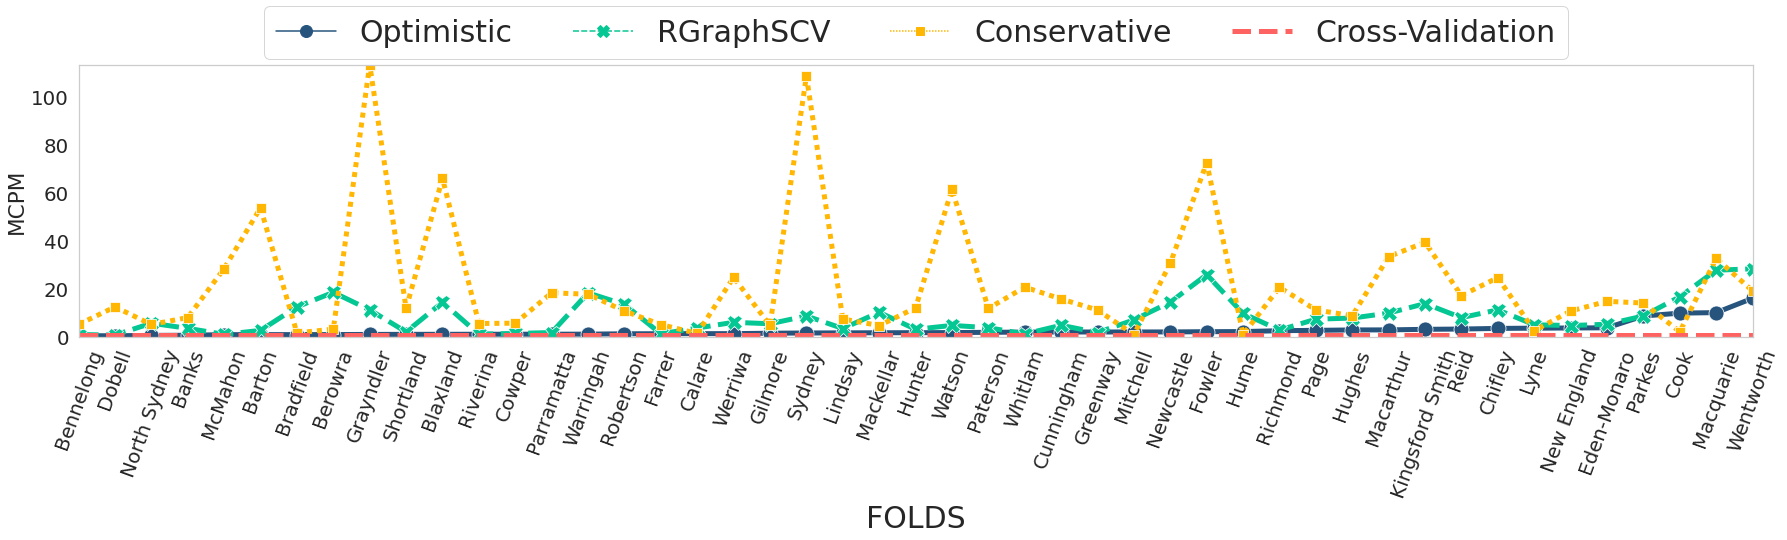

In [6]:
#reorgnize_col = ["RegGBSCV_R_Kappa_0.0", "Optimistic", "TraditionalSCV", "RBuffer", "CrossValidation"]
#metric_results = metric_results[reorgnize_col]
if "Brazil" in env_var["root_path"]:
    new_name = [br_folds[fold]["nome"] for fold in metric_results["Folds"]]
    metric_results["Folds"] = new_name

#palette = [ "#26547dff", "#05c793ff","#ffb703ff", "#bc5090ff" ]
palette = [ "#26547dff", "#05c793ff","#ffb703ff"]
sns.set(font_scale=1.8)
sns.set_style("whitegrid", {'axes.grid' : False})
fig, ax = plt.subplots(figsize=(30,5))
sns.lineplot(data=metric_results,ax=ax, x="Folds", y=metric, hue="SCV", 
             palette=palette, lw=5, markers=True, dashes=True, style="SCV", markersize=15)
ax.set_title("")
ax.axhline(cv_metrics_lat_lon[metric].mean(), linewidth = 5, color="#ff6361ff", label="Cross-Validation", ls='--')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.27),
          fancybox=True, shadow=False, ncol=6, markerscale=2, fontsize=30)
ax.set_xlabel("FOLDS",fontsize=30)
ax.set(ylim=(0,metric_results[metric].max()))
ax.margins(0,0)
plt.xticks(rotation=70)

plt.savefig(os.path.join(env_var["root_path"], dataset, "latlon_vs_census",f"LATLON_{ml_method}_{metric}.jpg"), bbox_inches='tight', dpi=300)
